# Image data sets

In [2]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import corner
import logging
from sklearn.decomposition import PCA
import torch
from torch import nn

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

sys.path.append("../../")
from experiments.datasets import CelebALoader, ImageNetLoader



## Plotting function

In [3]:
def show_images(dataset, n=20, return_array=10000, train=True):
    if dataset == "celeba":
        loader = CelebALoader()
    elif dataset == "imagenet":
        loader = ImageNetLoader()
    else:
        raise ValueError(dataset)
        
    data = loader.load_dataset(train=train, dataset_dir="../data/samples/{}".format(dataset))
    
    fig = plt.figure(figsize=(5*3., 4*3.))
    
    for i in range(n):
        x, _ = data[np.random.randint(len(data) - 1)]
        x_ = np.transpose(np.array(x), [1,2,0]) / 256.
        ax = plt.subplot(4, 5, i+1)
        plt.imshow(x_)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.tight_layout()
    plt.show()
    
    return np.array([data[i][0].numpy() for i in range(return_array)])
    

## ImageNet

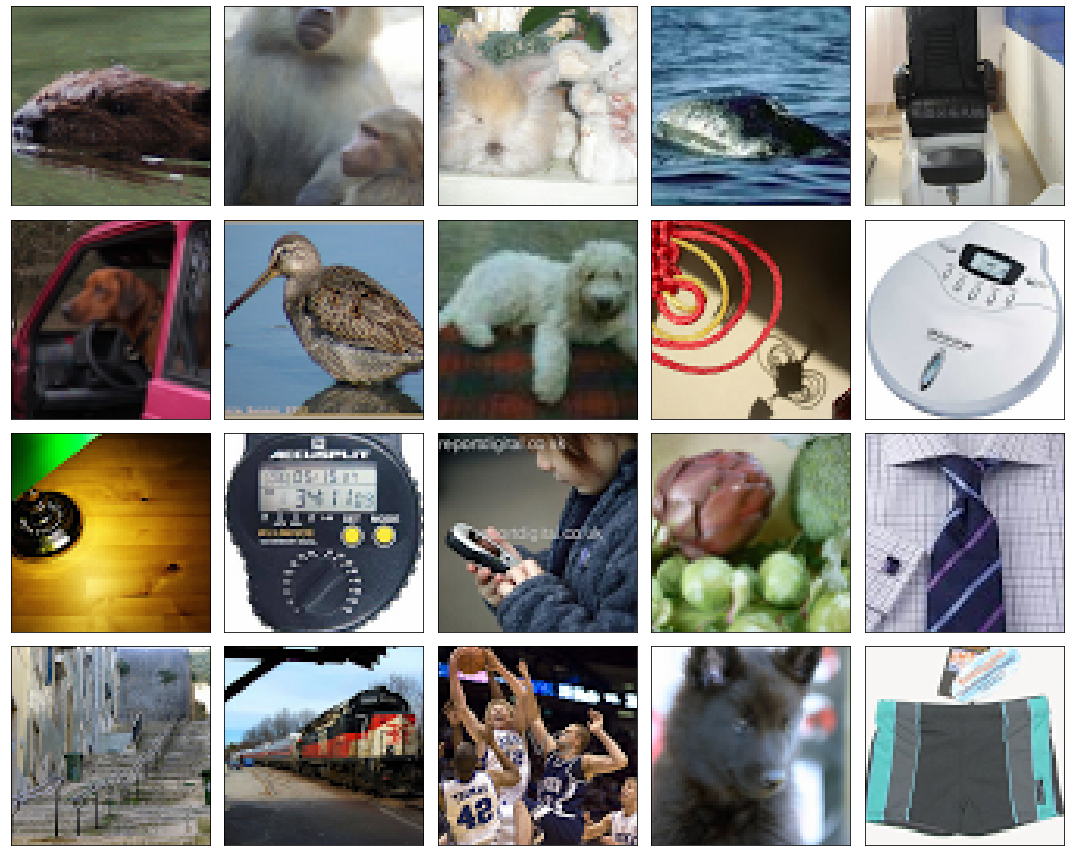

In [4]:
x_imagenet = show_images("imagenet")

## CelebA

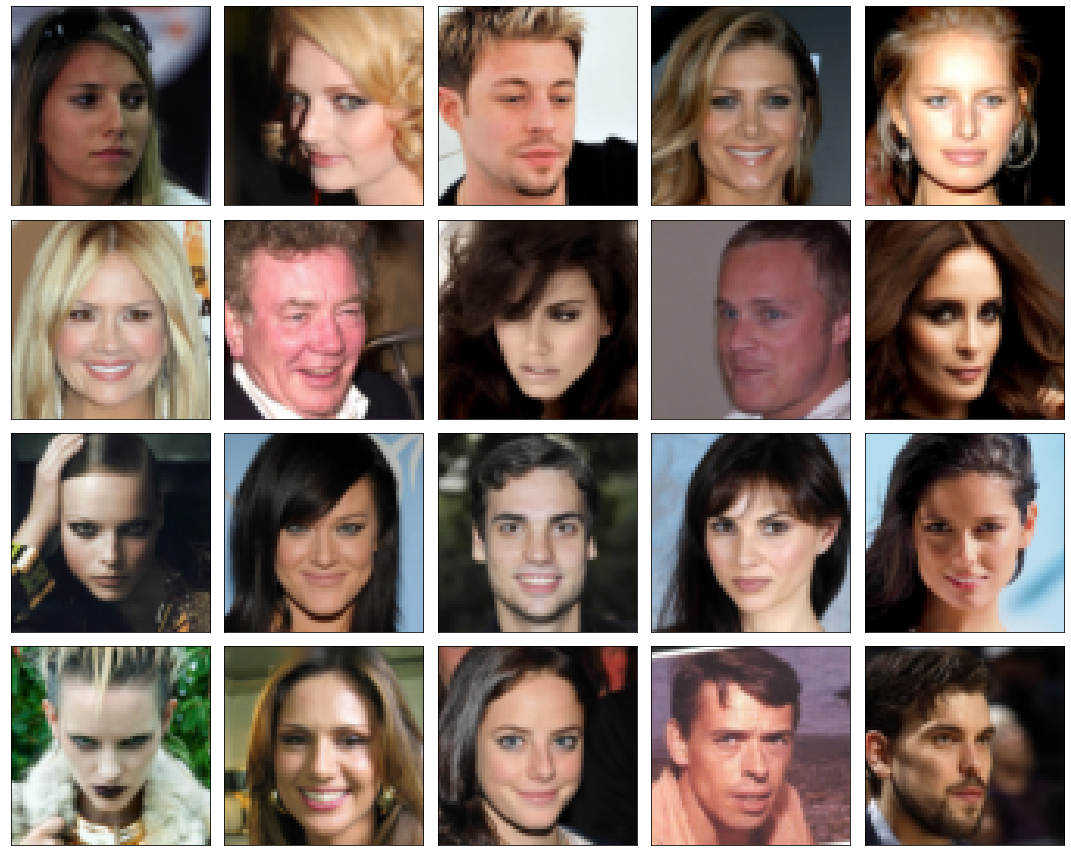

In [5]:
x_celeba = show_images("celeba")

## PCA

In [6]:
pca_celeba = PCA(n_components=1000)
pca_celeba.fit(x_celeba.reshape((10000, -1)))
exvar_celeba = pca_celeba.explained_variance_ratio_


In [7]:
pca_imagenet = PCA(n_components=1000)
pca_imagenet.fit(x_imagenet.reshape((10000, -1)))
exvar_imagenet = pca_imagenet.explained_variance_ratio_


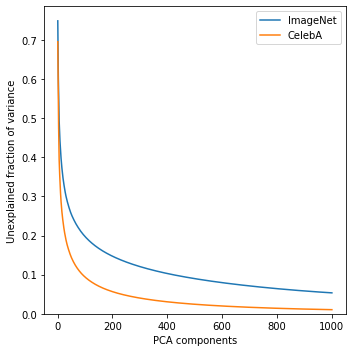

In [8]:
plt.figure(figsize=(5,5))

plt.plot(np.arange(1, 1001), 1. - np.cumsum(exvar_imagenet), label="ImageNet")
plt.plot(np.arange(1, 1001), 1. - np.cumsum(exvar_celeba), label="CelebA")

plt.legend()

plt.ylim(0.,None)
plt.xlabel("PCA components")
plt.ylabel("Unexplained fraction of variance")

plt.tight_layout()
plt.show()


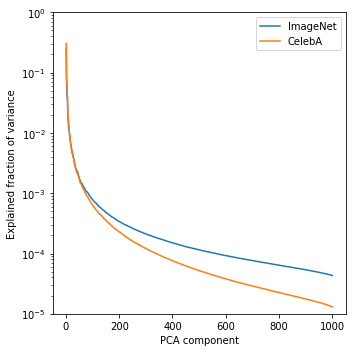

In [9]:
plt.figure(figsize=(5,5))

plt.plot(np.arange(1, 1001), exvar_imagenet, label="ImageNet")
plt.plot(np.arange(1, 1001), exvar_celeba, label="CelebA")

plt.legend()

plt.ylim(0.,None)
plt.xlabel("PCA component")
plt.ylabel("Explained fraction of variance")
plt.yscale("log")
plt.ylim(0.00001,1.)

plt.tight_layout()
plt.show()


## Autoencoders

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, dim):
        super(AutoEncoder, self).__init__()
        
        self.conv_encoder = nn.Sequential(              # (b,  3, 64, 64)
            nn.Conv2d(3,16, kernel_size=5, stride=1),   # (b, 16, 60, 60)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),                  # (b, 16, 30, 30)
            nn.Conv2d(16, 64, kernel_size=5, stride=1), # (b, 64, 26, 26)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),                  # (b, 64, 13, 13)
        )
        self.fc_encoder = nn.Sequential(
            nn.Linear(64*13*13, 1000),
            nn.ReLU(True),
            nn.Linear(1000, dim),
            nn.ReLU(True),
        )
        self.fc_decoder = nn.Sequential(
            nn.Linear(dim, 1000),
            nn.ReLU(True),
            nn.Linear(1000, 64*13*13),
            nn.ReLU(True),
        )
        self.conv_decoder = nn.Sequential(                                  # (b, 64, 13, 13)          
            nn.ConvTranspose2d(64,32, kernel_size=5, stride=2, padding=0),  # (b, 32, 29, 29) 
            nn.ReLU(True),
            nn.ConvTranspose2d(32,16, kernel_size=4, stride=2, padding=0),  # (b, 16, 60, 60) 
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size=5, stride=1, padding=0),  # (b,  3, 64, 64)
        )

    def forward(self, x):
        x = self.conv_encoder(x)
        x = x.view((x.size(0), -1))
        x = self.fc_encoder(x)
        x = self.fc_decoder(x)
        x = x.view((x.size(0), 64, 13, 13))
        x = self.conv_decoder(x)
        return x

In [11]:
def train(dim, epochs=10, batchsize=100, lr=3.e-4, wdecay=1.e-4):
    dataset = CelebALoader().load_dataset(train=True, dataset_dir="../data/samples/celeba")
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True, num_workers=4)
    model = AutoEncoder(dim)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wdecay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        total_loss = 0.
        for data in dataloader:
            x, _ = data
            x_reco = model(x)
            loss = criterion(x_reco, x)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(epoch)
            total_loss += loss.item()
            
        print('Epoch {}: reco error = {:.4f}'.format(epoch+1, total_loss / len(dataloader)))
    
    return model

In [12]:
def evaluate(model, batchsize=100):
    dataset = CelebALoader().load_dataset(train=False, dataset_dir="../data/samples/celeba")
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True, num_workers=4)
    criterion = nn.MSELoss()
    
    model.eval()
    total_loss = 0.
    
    with torch.no_grad():
        for batch, data in enumerate(dataloader):
            x, _ = data
            x_reco = model(x)
            total_loss += criterion(x_reco, x).item()
            
            if batch > 0:
                continue
                
            fig = plt.figure(figsize=(6*3., 5*3.))
            for i in range(15):
                ax = plt.subplot(5, 6, 2*i+1)
                x_ = np.transpose(np.array(x[i]), [1,2,0]) / 256.
                plt.imshow(x_)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                
                ax = plt.subplot(5, 6, 2*i+2)
                x_reco_ = np.transpose(np.array(x_reco[i]), [1,2,0]) / 256.
                plt.imshow(x_reco_)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

            plt.tight_layout()
            plt.show()
            
    return total_loss / len(dataloader)
        

In [13]:
models = {}
errors = {}

Epoch 1: reco error = 3703.4689
Epoch 2: reco error = 1582.3429
Epoch 3: reco error = 1189.0306
Epoch 4: reco error = 984.8625
Epoch 5: reco error = 857.2720
Epoch 6: reco error = 783.0454
Epoch 7: reco error = 737.6364
Epoch 8: reco error = 708.4836
Epoch 9: reco error = 691.7062
Epoch 10: reco error = 684.0411


15:15 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
15:15 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
15:15 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
15:15 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
15:15 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
15:15 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
15:15 matplotlib.image               WARNING Clipping input data to th

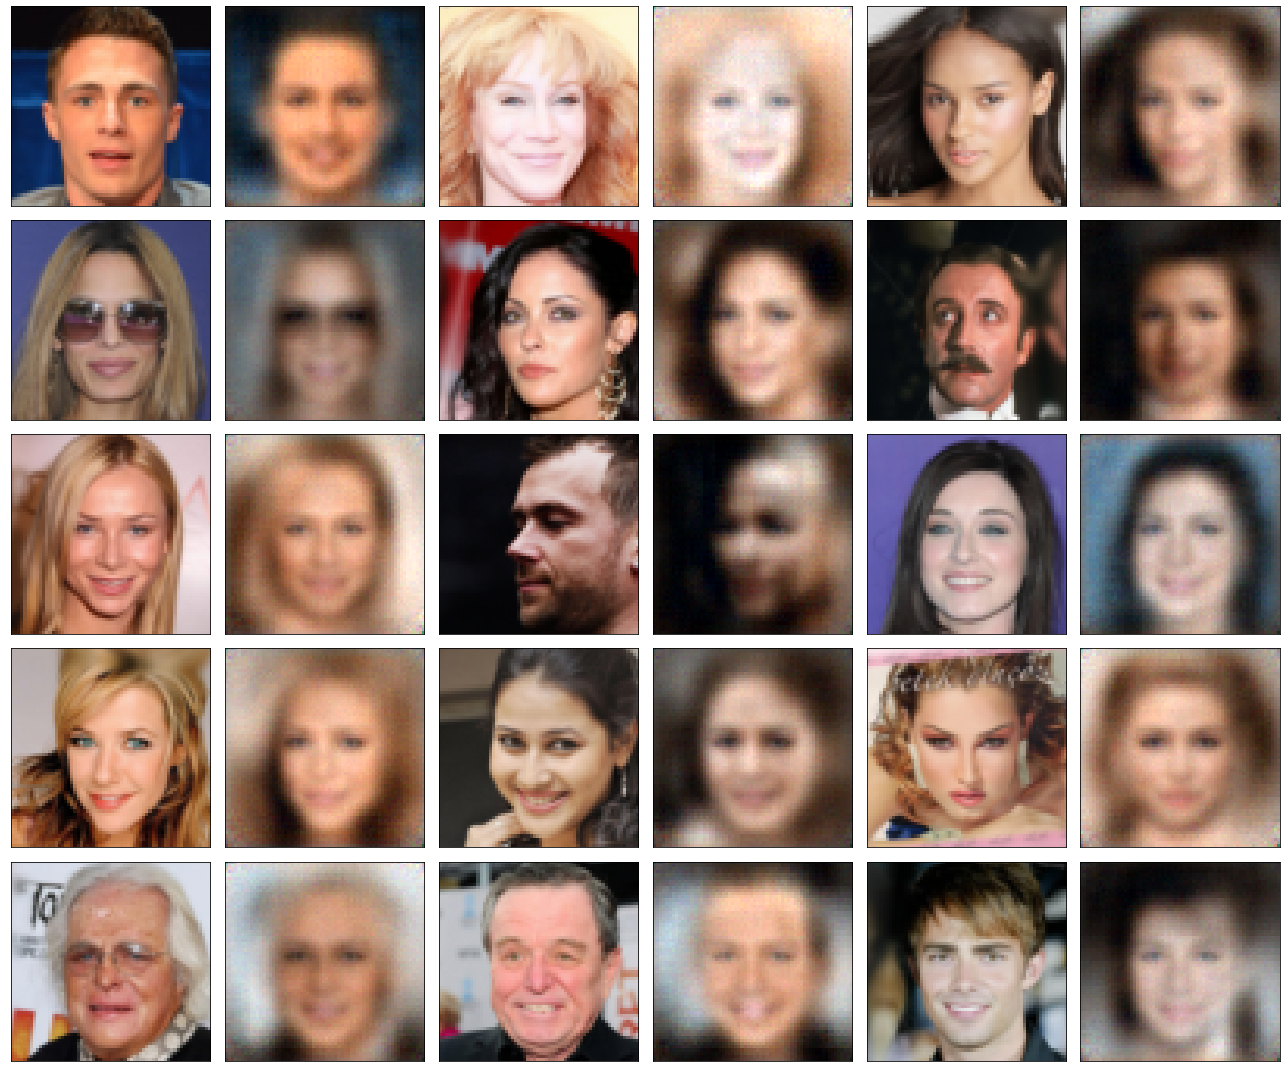

688.3800821940105

In [14]:
models[1000] = train(1000)
evaluate(models[1000])

Epoch 1: reco error = 3482.8622
Epoch 2: reco error = 1323.1468
Epoch 3: reco error = 1020.0927
Epoch 4: reco error = 859.0038
Epoch 5: reco error = 774.8789
Epoch 6: reco error = 725.4227
Epoch 7: reco error = 695.1621
Epoch 8: reco error = 675.5570
Epoch 9: reco error = 663.7030
Epoch 10: reco error = 658.3855


17:01 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
17:01 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
17:01 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
17:01 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
17:01 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
17:01 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
17:01 matplotlib.image               WARNING Clipping input data to th

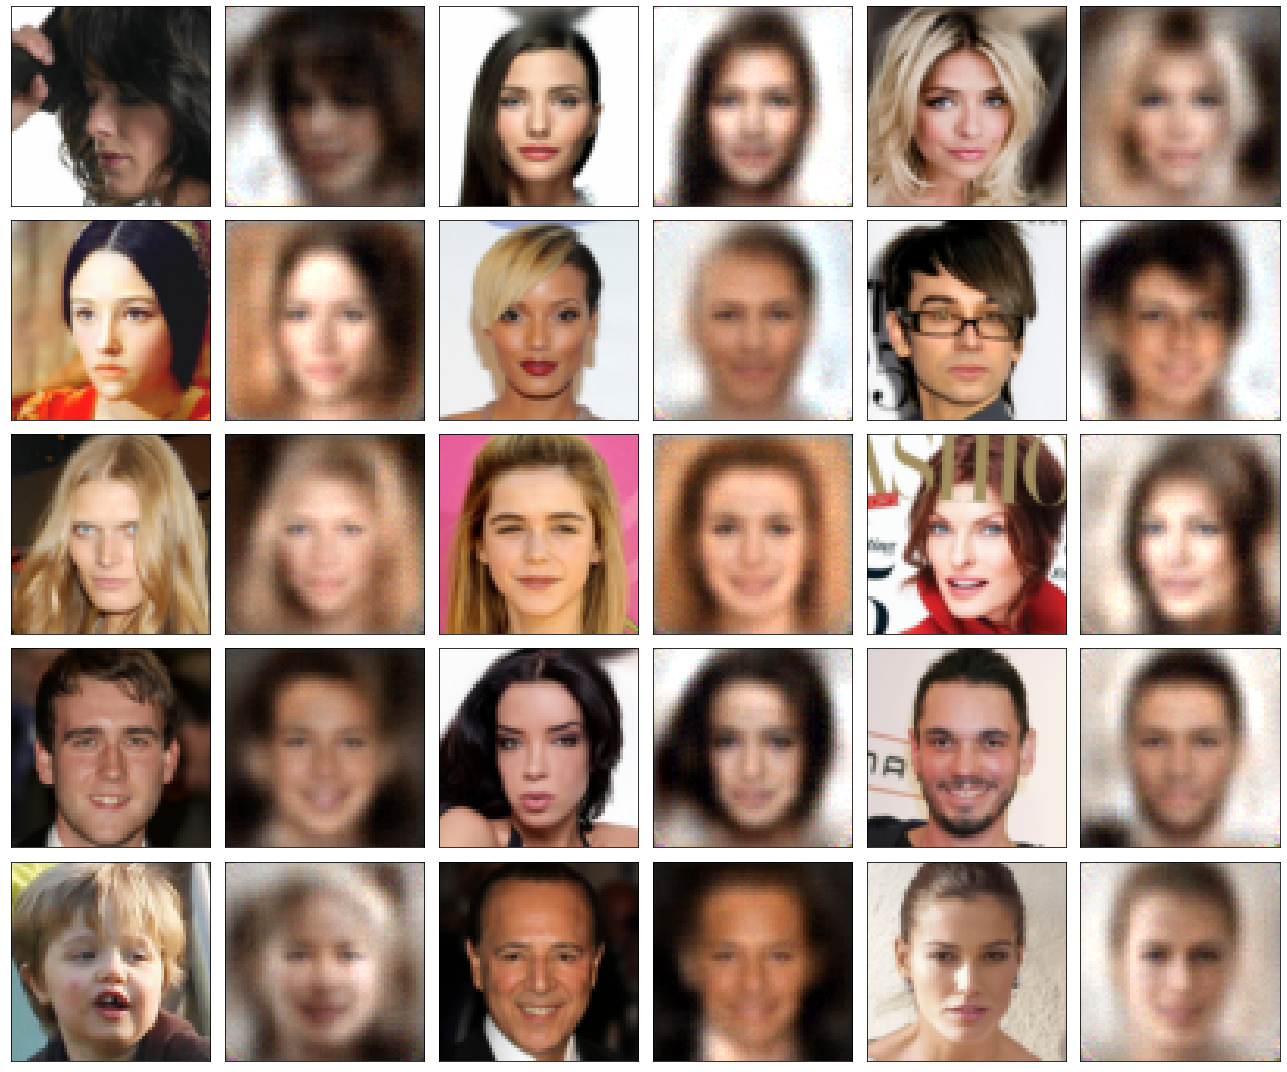

663.5796508789062

In [15]:
models[100] = train(100)
evaluate(models[100])

Epoch 1: reco error = 3850.8459
Epoch 2: reco error = 2393.0149
Epoch 3: reco error = 2337.0068
Epoch 4: reco error = 2303.1632
Epoch 5: reco error = 2278.6523
Epoch 6: reco error = 2260.5797
Epoch 7: reco error = 2246.6171
Epoch 8: reco error = 2233.0596
Epoch 9: reco error = 2223.4166
Epoch 10: reco error = 2219.1887


17:58 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
17:58 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


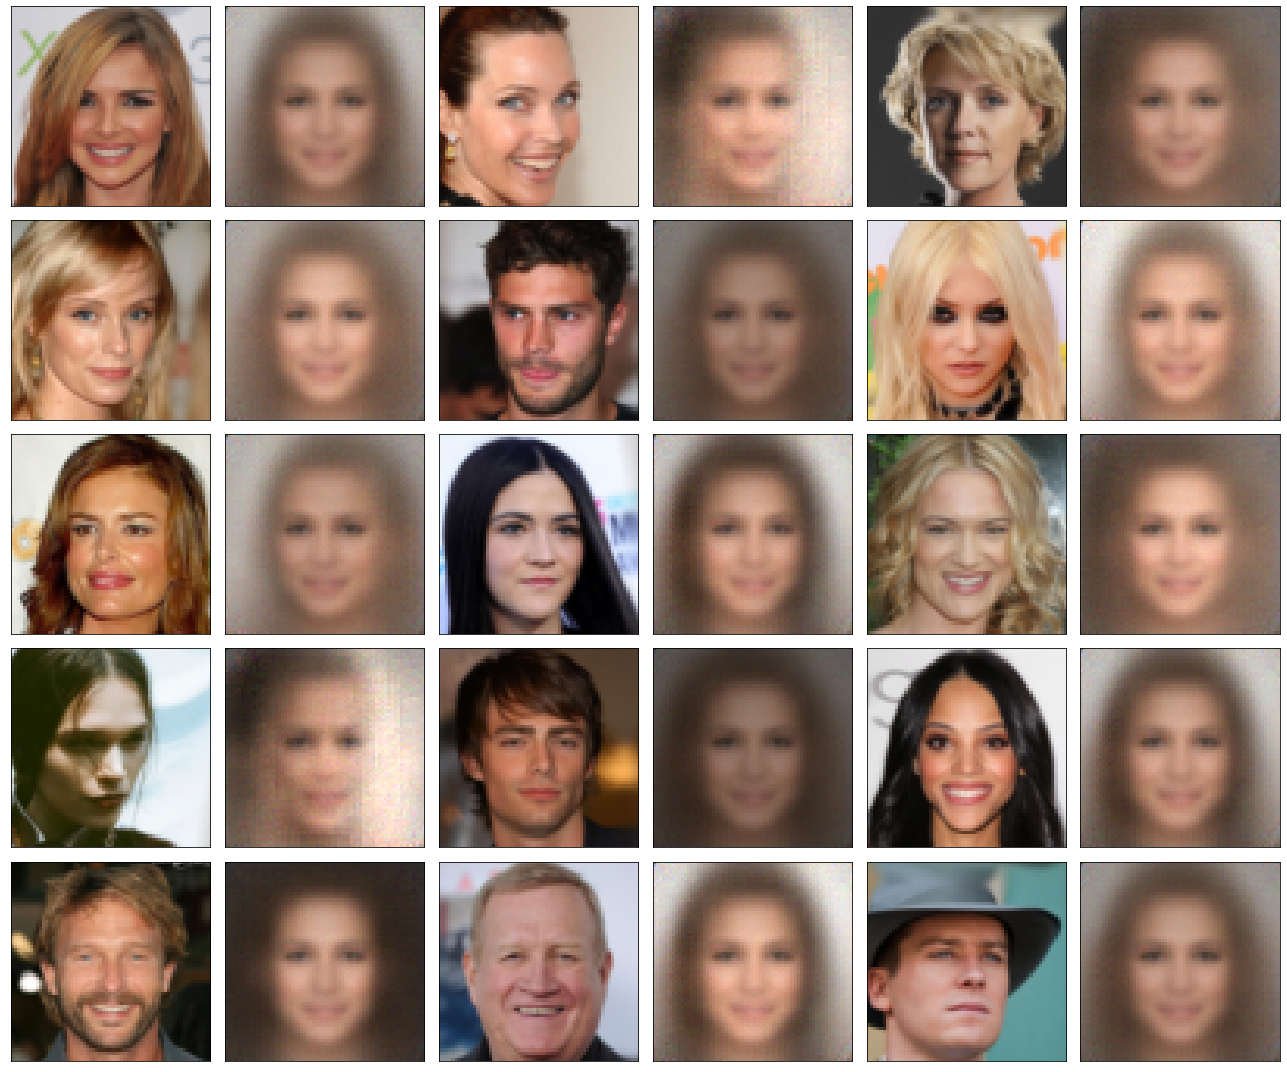

In [16]:
models[10] = train(10)
errors[10] = evaluate(models[10])

Epoch 1: reco error = 3752.1924
Epoch 2: reco error = 1540.5337
Epoch 3: reco error = 1165.8712
Epoch 4: reco error = 984.5677
Epoch 5: reco error = 854.9244
Epoch 6: reco error = 780.9956
Epoch 7: reco error = 735.5463
Epoch 8: reco error = 706.6188
Epoch 9: reco error = 689.7734
Epoch 10: reco error = 682.1225


18:54 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
18:54 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
18:54 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
18:54 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
18:54 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
18:54 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
18:54 matplotlib.image               WARNING Clipping input data to th

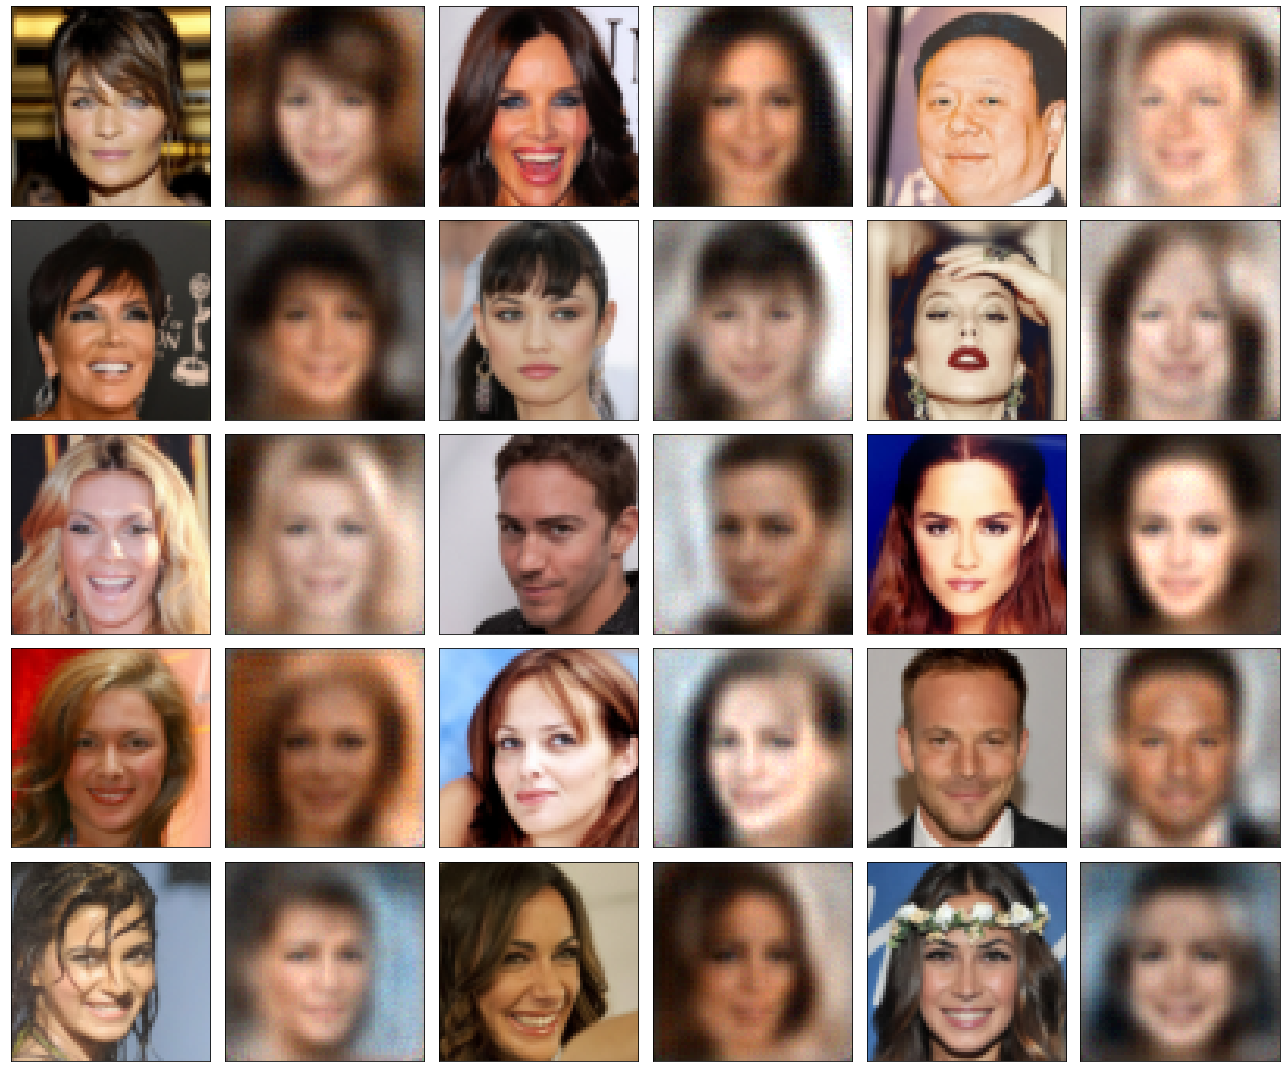

686.5082478841146

In [17]:
models[500] = train(500)
evaluate(models[500])

Epoch 1: reco error = 3972.5055
Epoch 2: reco error = 1455.8111
Epoch 3: reco error = 1138.4067
Epoch 4: reco error = 959.9381
Epoch 5: reco error = 870.1781
Epoch 6: reco error = 821.2995
Epoch 7: reco error = 787.7595
Epoch 8: reco error = 765.9527
Epoch 9: reco error = 753.4706
Epoch 10: reco error = 748.0656


19:42 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
19:42 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
19:42 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
19:42 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
19:42 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
19:42 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
19:42 matplotlib.image               WARNING Clipping input data to th

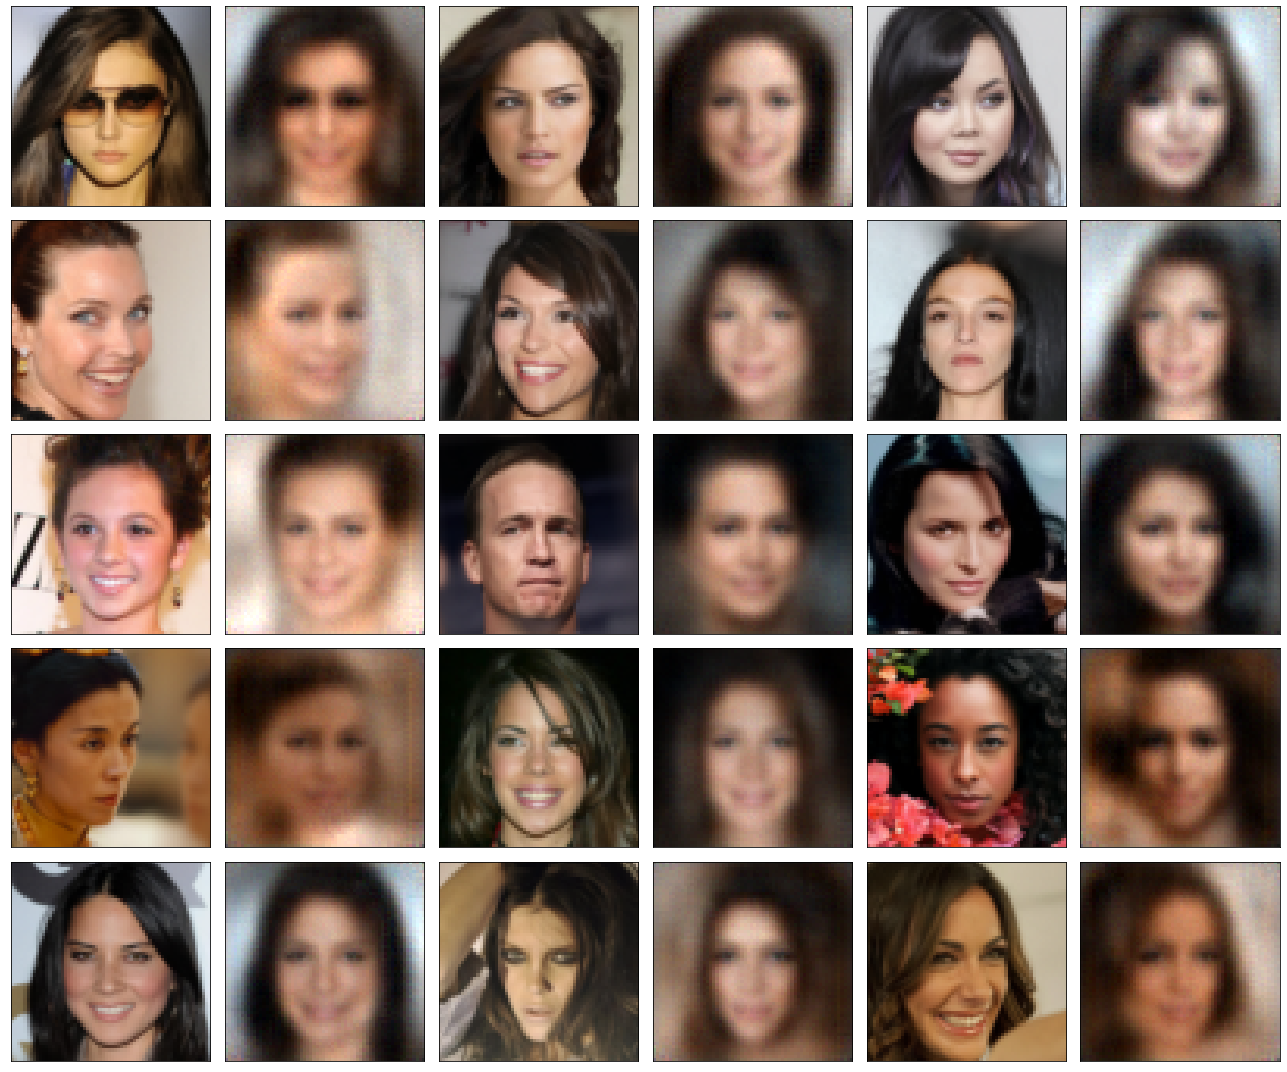

754.9320922851563

In [18]:
models[200] = train(200)
evaluate(models[200])

Epoch 1: reco error = 3608.0114
Epoch 2: reco error = 1448.9202
Epoch 3: reco error = 1208.6224
Epoch 4: reco error = 1097.6275
Epoch 5: reco error = 1044.5441
Epoch 6: reco error = 1019.0471
Epoch 7: reco error = 1003.3002
Epoch 8: reco error = 991.5185
Epoch 9: reco error = 983.1829
Epoch 10: reco error = 978.5820


20:37 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
20:37 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
20:37 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
20:37 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
20:37 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
20:37 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
20:37 matplotlib.image               WARNING Clipping input data to th

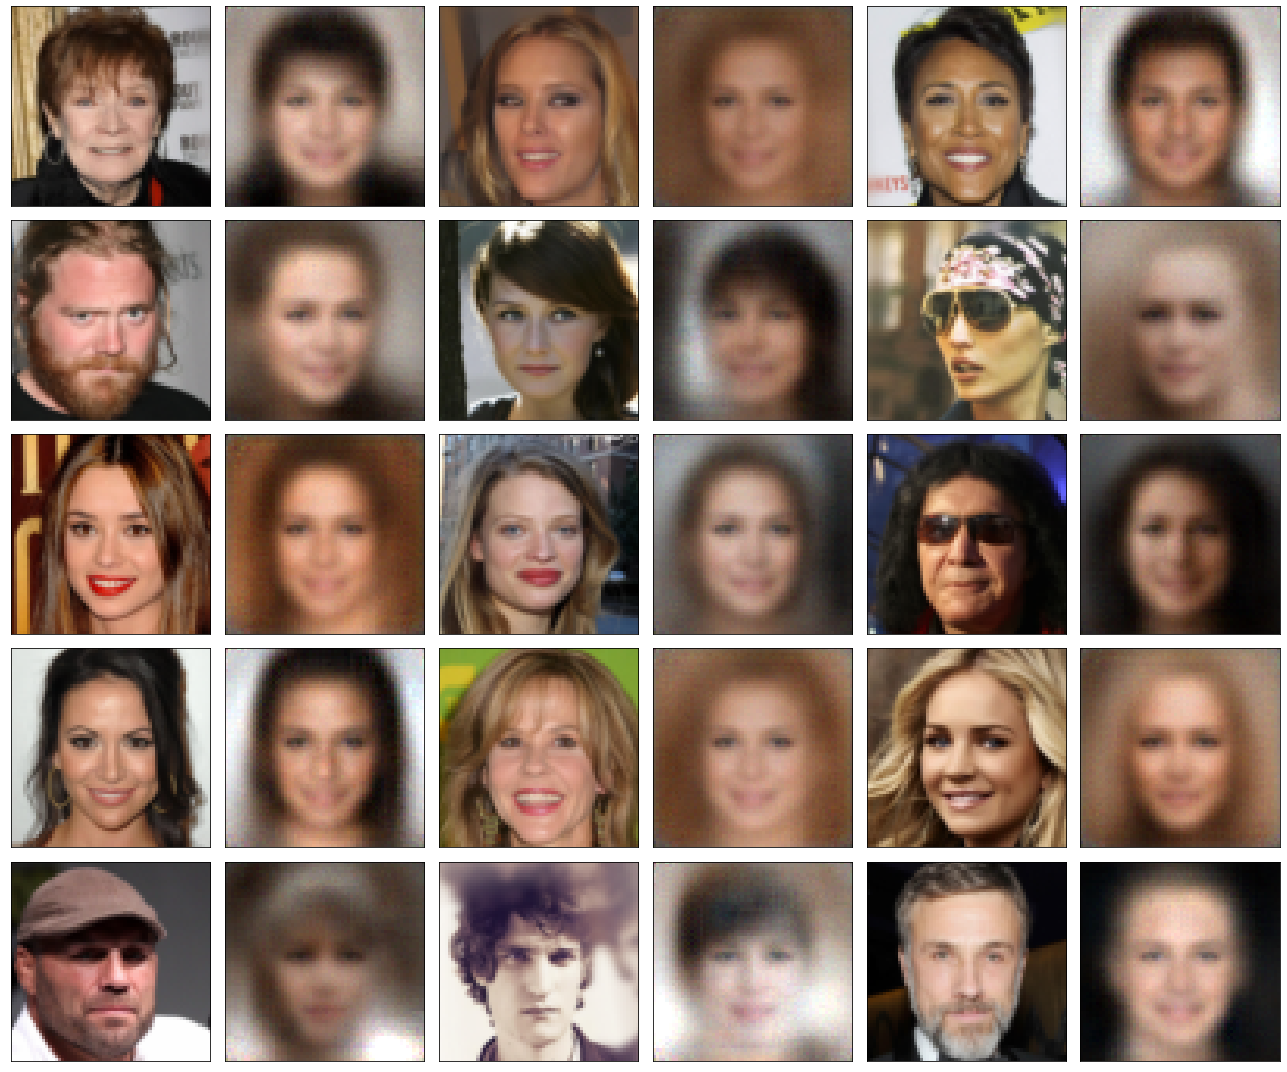

988.4304056803386

In [19]:
models[50] = train(50)
evaluate(models[50])

Epoch 1: reco error = 3255.4072
Epoch 2: reco error = 1342.8697
Epoch 3: reco error = 1195.6661
Epoch 4: reco error = 1150.8382
Epoch 5: reco error = 1114.8685
Epoch 6: reco error = 1090.2126
Epoch 7: reco error = 1074.2217
Epoch 8: reco error = 1062.3089
Epoch 9: reco error = 1055.1368
Epoch 10: reco error = 1050.9883


21:35 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
21:35 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
21:35 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
21:35 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
21:35 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
21:35 matplotlib.image               WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
21:35 matplotlib.image               WARNING Clipping input data to th

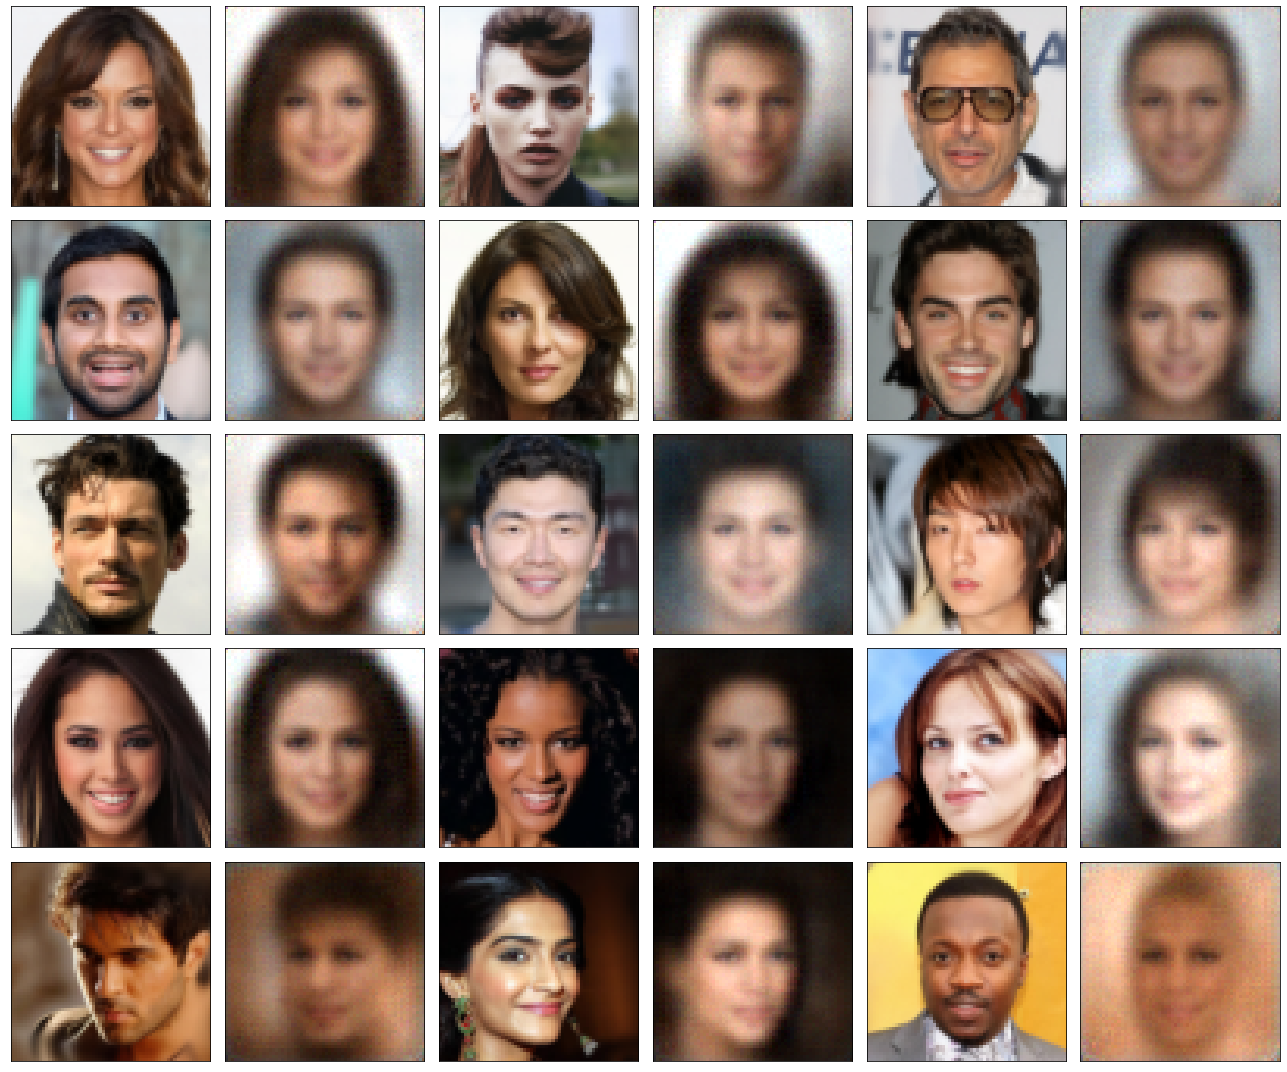

In [20]:
models[20] = train(20)
errors[20] = evaluate(models[20])